In [1]:
import requests  # go out and fetch
import pandas as pd
import numpy as np
import re
import seaborn as sns
import string
import os
import glob
import nltk
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anjalee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/anjalee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/anjalee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/anjalee/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Definitions for cleaning sentences and the wordcloud blurb copied from somewhere

In [2]:
def cleanup_sentences(sentence):
    text = re.sub('[^a-zA-Z]'," ", sentence) # Removing non a-z characters
    # text = sentence
    # print(sentence) # Print out non-cleaned text
    text = text.lower() # Lowering all text
    text = word_tokenize(text, language="english") # Splitting each word into an element of a list
    text = [lemma.lemmatize(word) for word in text if(word) not in stop_words] # Lemmatizing words and removing stopwords
    text = " ".join(text) # Putting words back into a single string. ['the', 'brown', 'cow'] --> 'the brown cow'
    # print(text, '\n') # Print out cleaned text
    return text

# wordcloud function
 
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
 
    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)
 
    plt.imshow(wordcloud)
    plt.show()

    


Set up to process the files in the /session_transcipts folder and call Lemmatizer

In [3]:
file_folder = '/Users/anjalee/Desktop/DemoFolder/pythonSubDir/session_transcripts/*.txt'
therapist = ["therapist:", "th:"]
patient = ["client:", "cl:"]
col_names = ['fname','therapist','original_sentence','sentence'] 
df = pd.DataFrame(columns=col_names)

ts_pattern = re.compile('\[\d\d:\d\d\:\d\d\]')
df_append = pd.DataFrame(columns=col_names)
p_dt = '\d\:\d\d\:\d\d' #timestamp pattern

stop_words = set(stopwords.words("english"))

lemma = WordNetLemmatizer()

Read all files from /session_transcripts

In [4]:
# Get files & put into dataframe (df)
folder = '/Users/anjalee/Desktop/DemoFolder/pythonSubDir/session_transcripts/*.txt'

for fpath in glob.iglob(folder):

    with open(fpath,'r') as f:
        fname = fpath.split("transcripts/")
        for line in f:
            ori_line = f.readline() # read line
            line = ori_line
    #CLEAN IN THIS ORDER
            
            line = line.lower() # lowercase
            line = re.sub(p_dt,'', line) # extract all timestamps
            #extract all stop_words

            df_append = pd.DataFrame(columns=col_names) # clear df_append from last time
            if ('therapist:' in line) or ('th:' in line):
                #remove the label from beginning of sentence
                line = line.removeprefix("therapist") 
                line = line.removeprefix("th")
                line = cleanup_sentences(line)

                # line = line.translate(str.maketrans('', '', string.punctuation)) # extract all punctuation
                # line = line.replace('\n','') #clean the \n off sentences
                df_append = pd.DataFrame([[fname,'1',ori_line, line]], columns=col_names) 

            elif ('client:' in line) or ('cl:' in line):
                line = line.removeprefix('client'); 
                line = line.removeprefix('cl')
                line = cleanup_sentences(line)
                # line = line.translate(str.maketrans('', '', string.punctuation))
                # line = line.replace('\n','') #clean the \n off sentences
                df_append = pd.DataFrame([[fname,'0',ori_line, line]], columns=col_names)     
            
            df = pd.concat([df, df_append]) #because append() is gone
            
            
            if not line:
                break
        

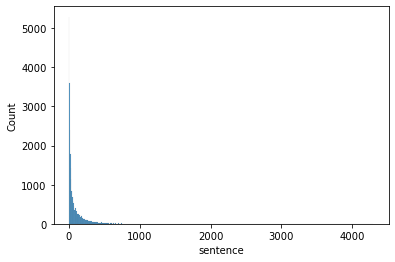

In [5]:
# Frequency
word_frequ = df["sentence"].str.split(expand=True).stack().value_counts()
# top 3 most frequent words are: like, yeah, know

## Length of the sentence using KDEplot
length = df["sentence"].str.len()
# sns.distplot(length)
sns.histplot(length)
plt.show()


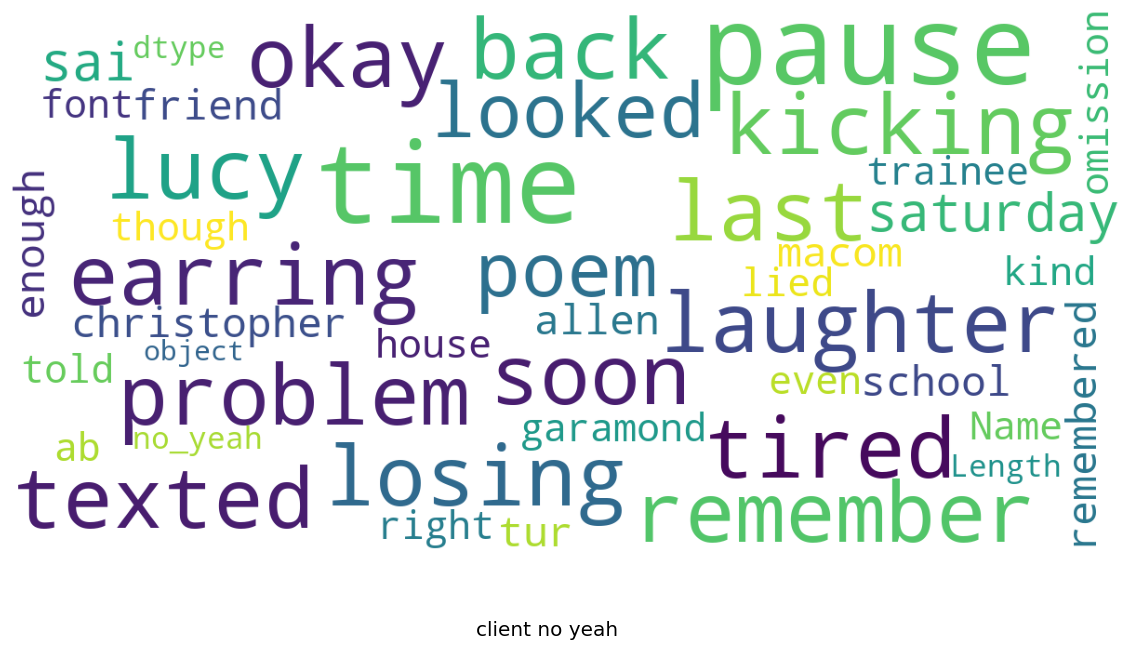

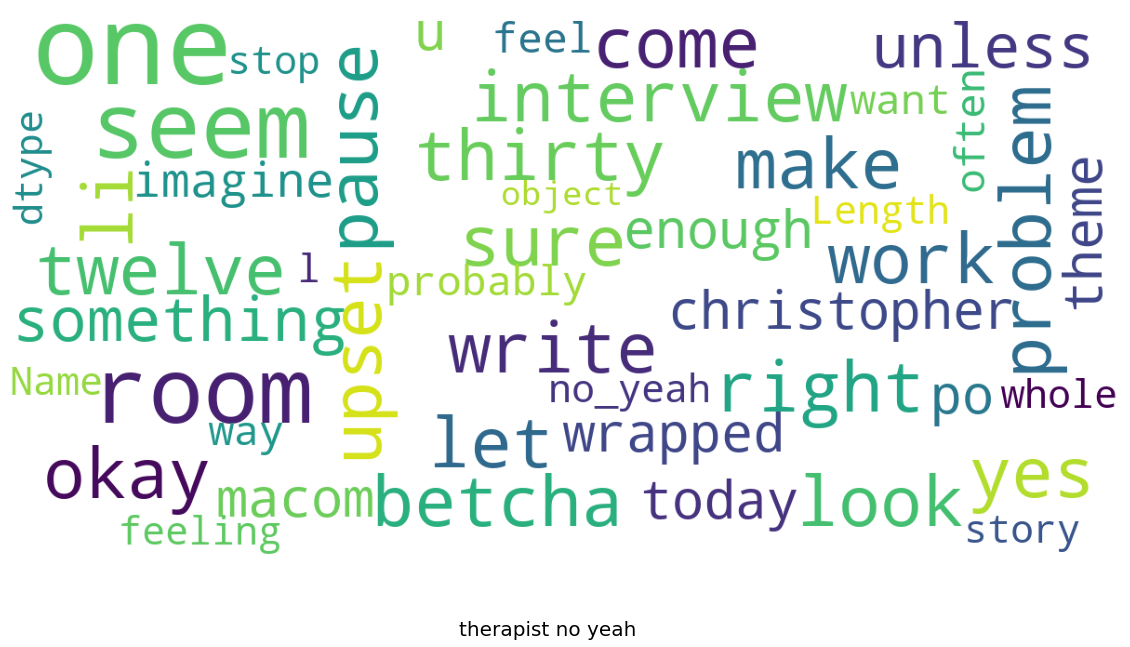

In [6]:
wc1 = []
# # get all words from client & therapist for eval

# words_cl = df['sentence'].loc[df["therapist"] == '0'].str.strip('()').str.split(',')
wc1 = df['sentence'].loc[df["therapist"] == '0'].dropna()
# wc = wc2[~np.isnan(wc2)].tolist()

# Take out the top 2 words that don't add to singular words but may add to phrases

df['no_yeah'] = df['sentence'].str.replace('yeah', '')
# df['no_like_yeah'] = df['no_like_yeah'].str.replace('like', '')


# WordClouds
# show_wordcloud(df['sentence'],title='original'); show_wordcloud(df['no_yeah'],title='no yeah');

# client before and after removal of yeah
# show_wordcloud(df['sentence'].loc[df["therapist"] == '0'], "client"); 
show_wordcloud(df['no_yeah'].loc[df["therapist"] == '0'], "client no yeah")

# therapist before and after removal of yeah
# show_wordcloud(df['sentence'].loc[df["therapist"] == '1'], "therapist"); 
show_wordcloud(df['no_yeah'].loc[df["therapist"] == '1'], "therapist no yeah")

c_df <= MAKE A COPY OF THE ORIGINAL DF

In [7]:
c_df = df.copy()

Fix the types and parse file names and session times

In [9]:
#fix therapist type to int -> bool
c_df['therapist'] = c_df['therapist'].astype(int)
c_df.iloc[:,1] = c_df.iloc[:,1].astype(bool)
c_df['fname'] = c_df['fname'].astype(str)
c_df.dtypes

fname                object
therapist              bool
original_sentence    object
sentence             object
no_yeah              object
dtype: object

Change fname into client_name and session_date. Then drop fname.

In [10]:
temp_df = pd.DataFrame()
temp_df = c_df['fname'].str.split(r"Client\_\_|\_\_Session\_", expand=True)
c_df['client_name'] = temp_df[1].str.split("_",expand=True)[0]



In [11]:
t2 = temp_df[2].str.split(r"_|\.",expand=True)
c_df['session_time'] = t2[3] + "-" +t2[0] + "-" + t2[1]
c_df = c_df.drop('fname', axis=1)


In [12]:
c_df.describe()

,therapist,original_sentence,sentence,no_yeah,client_name,session_time
count,28926,28926,28926,28926,28926,28926
unique,2,24083,21701,21700,21,263
top,False,THERAPIST: Yeah.\n,yeah,,Ma,2014-March-06
freq,14684,721,1357,1829,5033,424


In [13]:
c_df.to_csv("1out.csv", index=False)

#Analyses

Get Frequency
Word Cloud
- Word Cloud between client and therapist
- classification between client and therapist
TFIDF
<!-- from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features = 1500) # TF-IDF
X = tfidf.fit_transform(text_reviews).toarray() # TF-IDF -->
NER
HuggingFace to see how similar therapists sentences are to each other within a session

TF crashes the kernel everytime